# ARIMA Return Prediction Workflow

Pipeline:
1. Load & clean raw OHLCV data
2. ARIMA (p,q) search helper
3. Walk-forward prediction on returns
4. Sign quality & simple strategy construction
5. Performance metrics & cumulative plots
6. Export notebook to HTML report

Adjust parameters (horizon, p_max, q_max) in the configuration cell before running.


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

### 1. Imports

In [2]:
# Load CSV into DataFrame and clean columns
import pandas as pd

# Read raw file
df = pd.read_csv('Jam Petr.-i.csv')

# Inspect raw columns (they include angle brackets and duplicates for <OPENINT>)
# Example raw columns: ['<TICKER>', '<DTYYYYMMDD>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>', '<OPENINT>', '<OPENINT>.1', '<OPENINT>.2']

# Base rename mapping (non-duplicated)
rename_map = {
    '<TICKER>': 'ticker',
    '<DTYYYYMMDD>': 'date',
    '<OPEN>': 'open',
    '<HIGH>': 'high',
    '<LOW>': 'low',
    '<CLOSE>': 'close',
    '<VOL>': 'volume',
    '<OPENINT>': 'open_interest',
    '<OPENINT>.1': 'open_interest_1',
    '<OPENINT>.2': 'open_interest_2'
}

# Apply rename for columns that exist
existing_renames = {c: r for c, r in rename_map.items() if c in df.columns}
df = df.rename(columns=existing_renames)

# Convert date from yyyymmdd integer/string to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d', errors='coerce')

# Optional: sort by date and set as index (comment out if not desired)
df = df.sort_values('date').reset_index(drop=True)
df["return"] = df["close"].pct_change()

# Show cleaned head
df.head()

,ticker,date,open,high,low,close,volume,open_interest,open_interest_1,open_interest_2,return
0,جم-ا,2015-08-08,0.00,0.0,0.0,533.33,533.0,0.000000e+00,0,533.0,NaN
1,جم-ا,2015-08-09,3977.60,3984.0,3915.0,3974.93,533.0,1.054368e+10,114,533.0,6.453040
2,جم-ا,2015-08-10,3978.67,3988.0,3867.0,3957.33,3975.0,4.531556e+09,86,3975.0,-0.004428
3,جم-ا,2015-08-12,3972.27,3972.0,3840.0,3949.87,3957.0,1.388058e+09,46,3957.0,-0.001885
4,جم-ا,2015-08-15,3946.67,3983.0,3893.0,3953.60,3950.0,2.791638e+09,80,3950.0,0.000944


### 2. Load & Clean Data
Reads the raw CSV, renames columns, parses date, computes simple returns.

In [3]:
# Simple ARIMA (p,d,q) search varying only p and q (no seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import warnings

def simple_arima_pq_search(series, p_max=5, q_max=5, d=0, criterion='aic', dropna=True, verbose=True):
    """Search ARIMA(p,d,q) over p=0..p_max and q=0..q_max.

    Parameters
    ----------
    series : pd.Series
        Univariate time series (datetime index optional).
    p_max, q_max : int
        Maximum AR and MA orders.
    d : int
        Differencing order to use (commonly 0 or 1).
    criterion : {'aic','bic','aicc'}
        Information criterion to minimize.
    dropna : bool
        Drop NA values first.
    verbose : bool
        Print progress if True.

    Returns
    -------
    best_model : SARIMAXResults
    results_df : pd.DataFrame with columns [p,q,criterion]
    """
    if dropna:
        series = series.dropna()
    crit = criterion.lower()
    if crit not in {'aic','bic','aicc'}:
        raise ValueError("criterion must be 'aic','bic', or 'aicc'")

    rows = []
    best_score = np.inf
    best_model = None

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')
                    model = SARIMAX(series, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                    res = model.fit(disp=False)
                score = getattr(res, crit)
                rows.append({'p': p, 'q': q, crit: score})
                if score < best_score:
                    best_score = score
                    best_model = res
                if verbose:
                    print(f"p={p} q={q} {crit}={score:.2f} (best={best_score:.2f})")
            except Exception as e:
                if verbose:
                    print(f"p={p} q={q} failed: {e}")
                continue

    if not rows:
        raise RuntimeError("No ARIMA models fit successfully.")
    results_df = pd.DataFrame(rows).sort_values(by=crit).reset_index(drop=True)
    return best_model, results_df



### 3. ARIMA (p,q) Search Helper
Scans combinations of p and q (with fixed d) and returns best model by information criterion.

In [4]:
df

,ticker,date,open,high,low,close,volume,open_interest,open_interest_1,open_interest_2,return
0,جم-ا,2015-08-08,0.00,0.0,0.0,533.33,533.0,0.000000e+00,0,533.0,NaN
1,جم-ا,2015-08-09,3977.60,3984.0,3915.0,3974.93,533.0,1.054368e+10,114,533.0,6.453040
2,جم-ا,2015-08-10,3978.67,3988.0,3867.0,3957.33,3975.0,4.531556e+09,86,3975.0,-0.004428
3,جم-ا,2015-08-12,3972.27,3972.0,3840.0,3949.87,3957.0,1.388058e+09,46,3957.0,-0.001885
4,جم-ا,2015-08-15,3946.67,3983.0,3893.0,3953.60,3950.0,2.791638e+09,80,3950.0,0.000944
...,...,...,...,...,...,...,...,...,...,...,...
2420,جم-ا,2025-08-25,37620.00,37620.0,36850.0,37930.00,37980.0,3.935584e+09,75,37980.0,-0.001316
2421,جم-ا,2025-08-26,36800.00,36850.0,36800.0,37280.00,37930.0,5.484527e+10,95,37930.0,-0.017137
2422,جم-ا,2025-08-27,36170.00,37000.0,36170.0,36170.00,37280.0,1.527220e+11,241,37280.0,-0.029775
2423,جم-ا,2025-08-30,35090.00,36700.0,35090.0,35690.00,36170.0,4.371232e+10,118,36170.0,-0.013271


### 4. Inspect Cleaned DataFrame

In [5]:
# Rolling walk-forward ARIMA predictions on returns for the last N days
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Configuration
horizon = 60              # number of last days to predict (walk-forward)
col_return = 'return'     # target column
col_pred = 'pred_return'  # prediction column to create/fill
p_max, q_max = 2, 2       # search bounds for p and q
d = 0                     # differencing order for returns (usually 0 for returns)
criterion = 'aic'         # information criterion
re_search_each_day = False  # if True, re-run grid search each step (slower)
verbose_search = False

assert col_return in df.columns, f"Column '{col_return}' not found in df"

n = len(df)
if horizon >= n:
    raise ValueError("Horizon is larger than or equal to dataframe length.")

# Ensure prediction column exists & is NaN
if col_pred not in df.columns:
    df[col_pred] = np.nan
else:
    df.loc[:, col_pred] = df[col_pred]

start_pred_idx = n - horizon  # index of first day to predict in the rolling window

# Initial training series excludes the last `horizon` rows
initial_train = df.loc[:start_pred_idx - 1, col_return].dropna()

# Run initial (p,q) search once
best_p = best_q = None
if not re_search_each_day:
    best_model_init, results_df_init = simple_arima_pq_search(
        initial_train,
        p_max=p_max,
        q_max=q_max,
        d=d,
        criterion=criterion,
        dropna=True,
        verbose=verbose_search
    )
    best_p = int(results_df_init.iloc[0]['p'])
    best_q = int(results_df_init.iloc[0]['q'])
    print(f"Initial best order (p,d,q)=({best_p},{d},{best_q}) {criterion}={results_df_init.iloc[0][criterion]:.2f}")

predictions = []
indices = []

for offset in range(horizon):
    pred_idx = start_pred_idx + offset  # row to predict
    # Training data includes all data strictly before pred_idx (walk-forward expanding window)
    train_series = df.loc[:pred_idx - 1, col_return].dropna()

    # Optionally re-run search each day
    if re_search_each_day:
        bm, resdf = simple_arima_pq_search(
            train_series,
            p_max=p_max,
            q_max=q_max,
            d=d,
            criterion=criterion,
            dropna=True,
            verbose=verbose_search
        )
        bp = int(resdf.iloc[0]['p'])
        bq = int(resdf.iloc[0]['q'])
    else:
        bp, bq = best_p, best_q

    # Fit model with chosen order
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            model = SARIMAX(train_series, order=(bp, d, bq), enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)
        fc = res.get_forecast(steps=1)
        pred_value = float(fc.predicted_mean.iloc[0])
    except Exception as e:
        print(f"Prediction failed at index {pred_idx}: {e}")
        pred_value = np.nan

    df.at[pred_idx, col_pred] = pred_value
    predictions.append(pred_value)
    indices.append(pred_idx)

# Evaluation metrics over horizon (where both actual & predicted are present and not NaN)
actual = df.loc[indices, col_return]
pred = df.loc[indices, col_pred]
mask = (~actual.isna()) & (~pred.isna())
if mask.sum() > 0:
    mse = np.mean((actual[mask] - pred[mask]) ** 2)
    mae = np.mean(np.abs(actual[mask] - pred[mask]))
    print(f"Walk-forward evaluation over last {horizon} days: MSE={mse:.6f} MAE={mae:.6f} (n={mask.sum()})")
else:
    print("No valid predictions to evaluate.")

# Display the tail with key columns
cols_to_show = ['date', col_return, col_pred]
print(df[cols_to_show].tail(horizon + 5))

df.tail()

Initial best order (p,d,q)=(1,0,1) aic=-11725.17


c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a su

Walk-forward evaluation over last 60 days: MSE=0.000294 MAE=0.011086 (n=60)
           date    return  pred_return
2360 2025-05-25 -0.003558          NaN
2361 2025-05-26 -0.001857          NaN
2362 2025-05-27  0.000000          NaN
2363 2025-05-28 -0.001002          NaN
2364 2025-05-31 -0.000716          NaN
...         ...       ...          ...
2420 2025-08-25 -0.001316    -0.002700
2421 2025-08-26 -0.017137     0.001171
2422 2025-08-27 -0.029775    -0.003906
2423 2025-08-30 -0.013271    -0.002983
2424 2025-08-31 -0.000280    -0.000623

[65 rows x 3 columns]


c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\mrgha\Desktop\Trader_iran\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,ticker,date,open,high,low,close,volume,open_interest,open_interest_1,open_interest_2,return,pred_return
2420,جم-ا,2025-08-25,37620.0,37620.0,36850.0,37930.0,37980.0,3.935584e+09,75,37980.0,-0.001316,-0.002700
2421,جم-ا,2025-08-26,36800.0,36850.0,36800.0,37280.0,37930.0,5.484527e+10,95,37930.0,-0.017137,0.001171
2422,جم-ا,2025-08-27,36170.0,37000.0,36170.0,36170.0,37280.0,1.527220e+11,241,37280.0,-0.029775,-0.003906
2423,جم-ا,2025-08-30,35090.0,36700.0,35090.0,35690.0,36170.0,4.371232e+10,118,36170.0,-0.013271,-0.002983
2424,جم-ا,2025-08-31,35090.0,36640.0,34730.0,35680.0,35690.0,3.318872e+09,62,35690.0,-0.000280,-0.000623


### 5. Walk-Forward ARIMA Predictions
Expanding window; optionally re-search order each step.

In [6]:
df

,ticker,date,open,high,low,close,volume,open_interest,open_interest_1,open_interest_2,return,pred_return
0,جم-ا,2015-08-08,0.00,0.0,0.0,533.33,533.0,0.000000e+00,0,533.0,NaN,NaN
1,جم-ا,2015-08-09,3977.60,3984.0,3915.0,3974.93,533.0,1.054368e+10,114,533.0,6.453040,NaN
2,جم-ا,2015-08-10,3978.67,3988.0,3867.0,3957.33,3975.0,4.531556e+09,86,3975.0,-0.004428,NaN
3,جم-ا,2015-08-12,3972.27,3972.0,3840.0,3949.87,3957.0,1.388058e+09,46,3957.0,-0.001885,NaN
4,جم-ا,2015-08-15,3946.67,3983.0,3893.0,3953.60,3950.0,2.791638e+09,80,3950.0,0.000944,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2420,جم-ا,2025-08-25,37620.00,37620.0,36850.0,37930.00,37980.0,3.935584e+09,75,37980.0,-0.001316,-0.002700
2421,جم-ا,2025-08-26,36800.00,36850.0,36800.0,37280.00,37930.0,5.484527e+10,95,37930.0,-0.017137,0.001171
2422,جم-ا,2025-08-27,36170.00,37000.0,36170.0,36170.00,37280.0,1.527220e+11,241,37280.0,-0.029775,-0.003906
2423,جم-ا,2025-08-30,35090.00,36700.0,35090.0,35690.00,36170.0,4.371232e+10,118,36170.0,-0.013271,-0.002983


### 6. Intermediate Data Inspection

In [7]:
# Assess prediction sign quality and derive strategy return (fixed dtype handling)
import numpy as np

col_return = 'return'
col_pred = 'pred_return'
col_quality = 'prediction_quality'   # 'good' if signs match, else 'bad'
col_strategy = 'strategy_return'     # +abs(return) if good else -abs(return)

if col_return not in df.columns or col_pred not in df.columns:
    raise ValueError('Required columns missing')

ret = df[col_return]
pred = df[col_pred]

# Determine sign match (exclude rows with NaN in either)
sign_match = (np.sign(ret) == np.sign(pred)) & (~ret.isna()) & (~pred.isna())
have_both = (~ret.isna()) & (~pred.isna())

# Initialize quality column with NaN (object)
quality = np.full(len(df), None, dtype=object)
quality[have_both & sign_match] = 'good'
quality[have_both & (~sign_match)] = 'bad'

df[col_quality] = quality

# Strategy return: +|r| if good, -|r| if bad, else NaN
abs_ret = ret.abs()
strategy = np.full(len(df), np.nan)
strategy[have_both & sign_match] = abs_ret[have_both & sign_match]
strategy[have_both & (~sign_match)] = -abs_ret[have_both & (~sign_match)]

df[col_strategy] = strategy

# Summary metrics
valid = have_both
if valid.any():
    total = df.loc[valid, col_strategy].sum()
    avg = df.loc[valid, col_strategy].mean()
    hit_rate = sign_match.sum() / valid.sum()
    print(f"Hit rate: {hit_rate:.2%}  Cumulative strategy return: {total:.6f}  Average per-trade: {avg:.6f}")
else:
    print('No valid rows to evaluate.')

print(df[["date", col_return, col_pred, col_quality, col_strategy]].tail(15))

df.tail(60)

Hit rate: 55.00%  Cumulative strategy return: 0.195740  Average per-trade: 0.003262
           date    return  pred_return prediction_quality  strategy_return
2410 2025-08-10 -0.020929     0.000300                bad        -0.020929
2411 2025-08-11 -0.002114    -0.004162               good         0.002114
2412 2025-08-12 -0.000235     0.001800                bad        -0.000235
2413 2025-08-13 -0.000235    -0.000997               good         0.000235
2414 2025-08-16 -0.022610     0.000483                bad        -0.022610
2415 2025-08-17 -0.000723    -0.004580               good         0.000723
2416 2025-08-18 -0.020738     0.002283                bad        -0.020738
2417 2025-08-19 -0.026594    -0.005162               good         0.026594
2418 2025-08-20 -0.018973    -0.002357               good         0.018973
2419 2025-08-23 -0.020629    -0.002390               good         0.020629
2420 2025-08-25 -0.001316    -0.002700               good         0.001316
2421 2025-08-26 

,ticker,date,open,high,low,close,volume,open_interest,open_interest_1,open_interest_2,return,pred_return,prediction_quality,strategy_return
2365,جم-ا,2025-06-01,69750.0,69750.0,68470.0,69460.0,69760.0,3.461439e+10,397,69760.0,-0.004300,-0.000016,good,0.004300
2366,جم-ا,2025-06-02,69700.0,70000.0,68800.0,69290.0,69460.0,3.579903e+10,258,69460.0,-0.002447,-0.000805,good,0.002447
2367,جم-ا,2025-06-03,69290.0,69290.0,68470.0,69140.0,69290.0,2.811830e+10,446,69290.0,-0.002165,-0.000027,good,0.002165
2368,جم-ا,2025-06-07,69110.0,69110.0,67070.0,67760.0,69140.0,7.793003e+10,656,69140.0,-0.019960,-0.000395,good,0.019960
2369,جم-ا,2025-06-08,67730.0,68760.0,66830.0,67440.0,67760.0,4.872323e+10,336,67760.0,-0.004723,-0.003563,good,0.004723
2370,جم-ا,2025-06-09,67440.0,68070.0,65420.0,66540.0,67440.0,1.884882e+11,1338,67440.0,-0.013345,0.001037,bad,-0.013345
2371,جم-ا,2025-06-10,64550.0,64550.0,64550.0,64550.0,66540.0,1.329780e+11,1097,66540.0,-0.029907,-0.003086,good,0.029907
2372,جم-ا,2025-06-11,62620.0,62620.0,62620.0,62620.0,64550.0,1.480257e+11,1096,64550.0,-0.029899,-0.003995,good,0.029899
2373,جم-ا,2025-06-15,0.0,0.0,0.0,62620.0,62620.0,0.000000e+00,0,62620.0,0.000000,-0.003521,bad,-0.000000
2374,جم-ا,2025-06-16,0.0,0.0,0.0,62620.0,62620.0,0.000000e+00,0,62620.0,0.000000,0.001900,bad,-0.000000


### 7. Sign Quality & Simple Strategy
Classify predictions as good/bad by sign match; derive strategy return = +/-|r|.

In [8]:
df_result = df.tail(60)

### 8. Subset Last 60 Rows

Strategy period Sharpe (daily, unannualized): 0.1837
Approx annualized Sharpe: 2.9169


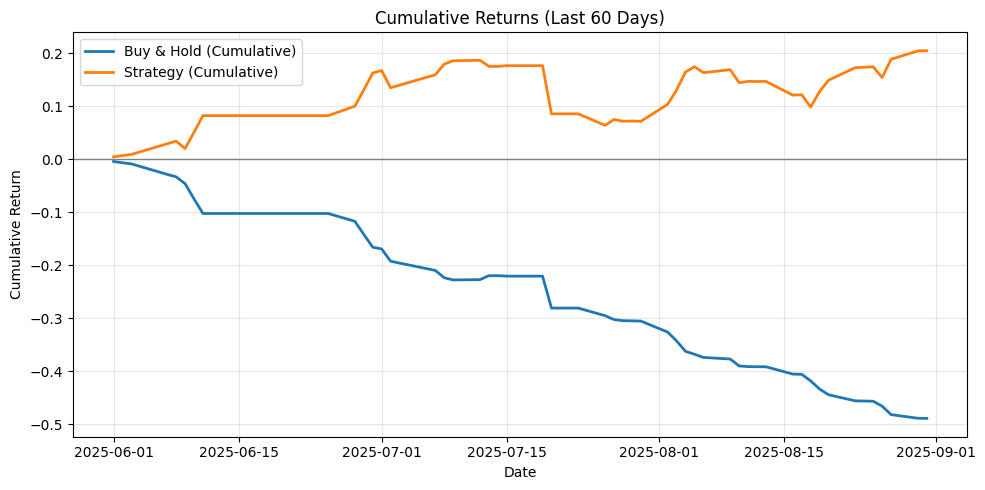

,date,return,strategy_return,buy_hold_cum,strategy_cum
2415,2025-08-17,-0.000723,0.000723,-0.405533,0.121516
2416,2025-08-18,-0.020738,-0.020738,-0.417861,0.098258
2417,2025-08-19,-0.026594,0.026594,-0.433343,0.127466
2418,2025-08-20,-0.018973,0.018973,-0.444094,0.148857
2419,2025-08-23,-0.020629,0.020629,-0.455562,0.172557
2420,2025-08-25,-0.001316,0.001316,-0.456279,0.174101
2421,2025-08-26,-0.017137,-0.017137,-0.465596,0.153980
2422,2025-08-27,-0.029775,0.029775,-0.481508,0.188340
2423,2025-08-30,-0.013271,0.013271,-0.488389,0.204110
2424,2025-08-31,-0.000280,0.000280,-0.488532,0.204447


In [9]:
# Compute cumulative returns & Sharpe ratio for last 60 rows (df_result)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if 'df_result' not in globals():
    df_result = df.tail(60).copy()
else:
    # Ensure copy to avoid SettingWithCopy warnings
    df_result = df_result.copy()

req_cols = ['return', 'strategy_return']
missing = [c for c in req_cols if c not in df_result.columns]
if missing:
    raise ValueError(f"Missing required columns in df_result: {missing}")

# Fill any remaining NaNs (e.g., first return) with 0 for compounding purposes
df_result['return_filled'] = df_result['return'].fillna(0)
df_result['strategy_return_filled'] = df_result['strategy_return'].fillna(0)

# Cumulative (1 + r).cumprod() - 1
df_result['buy_hold_cum'] = (1 + df_result['return_filled']).cumprod() - 1
df_result['strategy_cum'] = (1 + df_result['strategy_return_filled']).cumprod() - 1

# Daily Sharpe ratio (unannualized) = mean / std
ret_series = df_result['strategy_return_filled']
if ret_series.std() != 0:
    sharpe = ret_series.mean() / ret_series.std()
else:
    sharpe = np.nan

print(f"Strategy period Sharpe (daily, unannualized): {sharpe:.4f}")

# Optional annualization assuming ~252 trading days (adjust if needed)
ann_factor = np.sqrt(252)
ann_sharpe = sharpe * ann_factor
print(f"Approx annualized Sharpe: {ann_sharpe:.4f}")

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(df_result['date'], df_result['buy_hold_cum'], label='Buy & Hold (Cumulative)', linewidth=2)
plt.plot(df_result['date'], df_result['strategy_cum'], label='Strategy (Cumulative)', linewidth=2)
plt.axhline(0, color='gray', linewidth=1)
plt.title('Cumulative Returns (Last 60 Days)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display tail of result for quick inspection
df_result[['date','return','strategy_return','buy_hold_cum','strategy_cum']].tail(10)

### 9. Performance Metrics & Plot
Compute cumulative returns and (approx) Sharpe ratio.

### 10. Export Report
Run the next cell to export this executed notebook (with outputs) to HTML.

In [15]:
# === HTML REPORT EXPORT ===
# Save the notebook (Ctrl+S) BEFORE running this cell to capture latest outputs.
# Generates Trader_report.html in the same folder.

import sys, subprocess, pathlib, nbformat
from nbconvert import HTMLExporter

NOTEBOOK_NAME = 'Trader.ipynb'
nb_path = pathlib.Path(NOTEBOOK_NAME)
if not nb_path.exists():
    # Fallback: first *.ipynb file
    ipynbs = list(pathlib.Path('.').glob('*.ipynb'))
    if len(ipynbs) == 1:
        nb_path = ipynbs[0]
    else:
        raise FileNotFoundError(f"Cannot find {NOTEBOOK_NAME}; available: {[p.name for p in ipynbs]}")

print(f'Reading: {nb_path}')
nb = nbformat.read(nb_path.open('r', encoding='utf-8'), as_version=4)

exporter = HTMLExporter()
# Set to True to hide code cells in the report:
exporter.exclude_input = False

body, resources = exporter.from_notebook_node(nb)
out_file = nb_path.with_name(nb_path.stem + '_report.html')
out_file.write_text(body, encoding='utf-8')
print(f'HTML report written -> {out_file.resolve()}')
print('Done. You can open it in a browser.')

Reading: Trader.ipynb
HTML report written -> C:\Users\mrgha\Desktop\Trader_iran\Trader_report.html
Done. You can open it in a browser.
HTML report written -> C:\Users\mrgha\Desktop\Trader_iran\Trader_report.html
Done. You can open it in a browser.


In [ ]:
# ACF & PACF plots for return series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

ret_series = df['return'].dropna()
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret_series, ax=axes[0], lags=40, title='Return ACF (lags=40)')
plot_pacf(ret_series, ax=axes[1], lags=40, title='Return PACF (lags=40)', method='ywm')
plt.tight_layout()
plt.show()